# 使用Keras建立回归模型
上两讲中，我们都是进行分类任务。<br>
这一讲中，我们使用神经网络建立一个回归模型进行房价预测。<br>

## 数据集介绍
这一讲中，使用的是Boston房价数据集，该数据集讲述的是1970的中期阶段的房价。<br>
总共包含506个样本（404个训练样本，102个测试样本）

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import boston_housing
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# 导入数据集
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 1s 12us/step


In [4]:
# 查看数据集shape
print("The shape of train_data: ", train_data.shape)
print("The shape of train_targets: ", train_targets.shape)
print("The shape of test_data: ", test_data.shape)
print("The shape of test_targets: ", test_targets.shape)

The shape of train_data:  (404, 13)
The shape of train_targets:  (404,)
The shape of test_data:  (102, 13)
The shape of test_targets:  (102,)


从以上的shape中，可以看到，每个样本都是又13个特征组成的，例如犯罪率等这些特征。<br>
而target则是一个值，一个连续值。

In [5]:
# 查看每个样本的值
print("The train_data[0]: ", train_data[0])
print("The train_targets[0]: ", train_targets[0])

The train_data[0]:  [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
The train_targets[0]:  15.2


## 数据预处理
由于每个特征的量纲不同(即取值范围不同)，例如，犯罪率(0.0-1.0)，平均房间数量(>1)。<br>
将不同量纲的特征一起input到同一个神经网络中进行训练，会使得训练变难，所以我们需要进行数据标准化（不了解标准化的，可以回头看看我之前写的特征工程系列）。<br>
当然，你也可以选择不进行数据标准化，但这不是明智的选择。

In [6]:
# 获取平均值
mean = train_data.mean(axis=0)
print("The mean of features: ", mean)
train_data -= mean
# 获取标准差
std = train_data.std(axis=0)
print("The std of features：", std)
train_data /= std

# 当然，测试机也要进行同样的操作
test_data -= mean
test_data /= std

The mean of features:  [3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
The std of features： [9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


## 建立模型

In [12]:
def bulid_network(optimizer='rmsprop', loss='mse', metrics='mae'):
    # build
    # 由于数据集的规模比较小，所以我们尽量使用比较浅的模型，比较深的模型对于小数据集来说容易过拟合
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(Dense(units=64, activation='relu',))
    model.add(Dense(units=1))
    
    # compile
    # 这里使用mean square loss的loss function，因为这是个回归模型，而mse是回归模型中使用比较多的loss function
    # 表示真实值与预测值的残差平方和
    # metrics监控使用mean absolute error,平均绝对误差，和mse只是相差一个平方
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
    
    return model

## K-fold cross validation
**这里我们使用k-折叠交叉验证。**<br>
* 由于我们的数据是一个小数据集，如果我们按照7：3的比例进行划分训练集和验证集，则验证机也只是几十个样本左右。<br>
* 因为验证机的规模更小，很难全面包括整个数据集的真实分布，而模型的评价也要依靠验证集的评分，会造成很高的variance。
* 我们将训练集和划分为K份，然后进行1-k次的模型迭代，选择k-1份的作为训练集，剩余的为测试集，如图示：<br>
![title](images/k-fold.JPG)
* 然后分数为每次的验证分数的平均值。
* 通过k次的交叉验证，可以很大的掌握数据集的分布。

In [10]:
# 我们使用numpy来进行划分
# 划为k份
k = 4
# val_set的的样本数目
num_val_samples = len(train_data) // k
epochs = 100
all_scores = []   # 用于保存k次validation的score

In [13]:
for i in range(k):
    print('processing_fold #', i+1)
    # 开始划分数据
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_tagets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    # 进行组合
    partial_train_data = np.concatenate([train_data[0: i * num_val_samples ], train_data[( i + 1) *  num_val_samples: ]], axis=0)
    partial_train_targets = np.concatenate([train_targets[0: i * num_val_samples ], train_targets[( i + 1) *  num_val_samples: ]], axis=0)
    
    # 创建模型
    model = bulid_network()
    # verbose=0, 表示不输出训练信息
    model.fit(partial_train_data, partial_train_targets, epochs=epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_tagets, verbose=0)
    all_scores.append(val_mae)

processing_fold # 1
processing_fold # 2
processing_fold # 3
processing_fold # 4


In [16]:
# 查看分数
print('All scores: ', all_scores)
print('mean scores: ', np.mean(all_scores))

All scores:  [1.924640688565698, 2.4316208055703945, 2.514633008749178, 2.370800575407425]
mean scores:  2.3104237695731737


从结果中可以看到，每次的运行的分数都不一样（1.9-2.5)，但平均分2.3看起来更加的可靠点。

## 保存验证集的训练日志

In [17]:
epochs = 500
all_mae_histogries = []
for i in range(k):
    print('processing_fold #', i+1)
    # 开始划分数据
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_tagets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    # 进行组合
    partial_train_data = np.concatenate([train_data[0: i * num_val_samples ], train_data[( i + 1) *  num_val_samples: ]], axis=0)
    partial_train_targets = np.concatenate([train_targets[0: i * num_val_samples ], train_targets[( i + 1) *  num_val_samples: ]], axis=0)
    
    # 创建模型
    model = bulid_network()
    # verbose=0, 表示不输出训练信息
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_tagets), 
              epochs=epochs, batch_size=16, verbose=0)
    # 记录
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histogries.append(mae_history)

processing_fold # 1
processing_fold # 2
processing_fold # 3
processing_fold # 4


In [19]:
# 计算平均error,即每一个eoches，每个val_error的第epoches的平均值
average_mae_history = [np.mean([x[i] for x in all_mae_histogries]) for i in range(epochs)]

In [21]:
average_mae_history[:10]

[19.285466937735528,
 16.088818375426946,
 12.166197896003723,
 8.416106265960353,
 6.165305027277163,
 5.168594648342322,
 4.502406309441765,
 3.942890224775465,
 3.6919081860249587,
 3.4350295202566845]

## 将曲线绘制出来

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


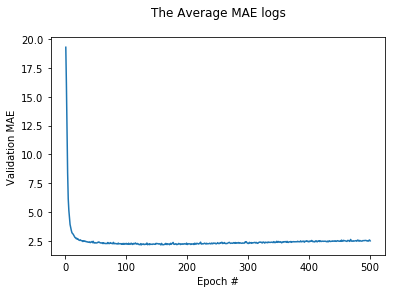

In [22]:
plt.plot(range(1, epochs + 1), average_mae_history)
plt.title('The Average MAE logs\n')
plt.xlabel('Epoch #')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

但从以上这幅图，我们感觉应该是在epoch=120左右，模型就已经停止改善了，并且开始过拟合。<br>
我们来证明这一点。<br>

## 平滑数据
* 由上图中看出，前10个epoch的数据variance比较大，所以我们舍弃这10个点。<br>
* 用剩余的点进行这样的操作：每个点替换为前面点的指数移动平均值，以获得平滑曲线。
* 那到底什么是指数移动平均（Exponential moving average, EMA, 它起到的效果是移动平均线能较好的反应时间序列的变化趋势，权重的大小不同起到的作用也是不同，时间比较久远的变量值的影响力相对较低，时间比较近的变量值的影响力相对较高*
* 这里不详细解释EMA，想更好地理解EMA，建议去看Andrew老师的Machine Learning课程哦*

In [37]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        # 已经存在数据，则用最后一个点的加权数据
        if smoothed_points:
            previous = smoothed_points[-1]
            point = previous * factor + point * (1 - factor)
            smoothed_points.append(point)
        else:
            # 第一个点
            smoothed_points.append(point)   
    return smoothed_points

In [38]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

E:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


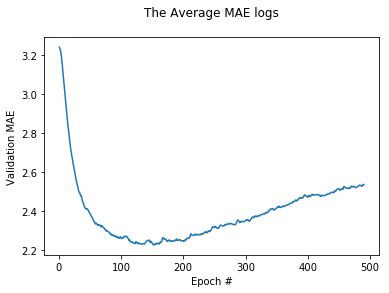

In [39]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('The Average MAE logs\n')
plt.xlabel('Epoch #')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

根据这张图，大概在epoch=120左右就已经开始过拟合了

In [45]:
# 重新训练
epochs = 120
model = bulid_network()
model.fit(partial_train_data, partial_train_targets, 
              epochs=epochs, batch_size=16, verbose=1)

Epoch 1/120
303/303 [==============================] - 0s 1ms/step - loss: 494.8398 - mean_absolute_error: 20.5458
Epoch 2/120
303/303 [==============================] - 0s 284us/step - loss: 376.2325 - mean_absolute_error: 17.6118
Epoch 3/120
303/303 [==============================] - 0s 241us/step - loss: 251.3917 - mean_absolute_error: 13.9028
Epoch 4/120
303/303 [==============================] - 0s 211us/step - loss: 142.8422 - mean_absolute_error: 9.8113
Epoch 5/120
303/303 [==============================] - 0s 230us/step - loss: 77.5235 - mean_absolute_error: 6.8604
Epoch 6/120
303/303 [==============================] - 0s 207us/step - loss: 49.8307 - mean_absolute_error: 5.2677
Epoch 7/120
303/303 [==============================] - 0s 214us/step - loss: 36.0941 - mean_absolute_error: 4.3068
Epoch 8/120
303/303 [==============================] - 0s 218us/step - loss: 28.2242 - mean_absolute_error: 3.6784
Epoch 9/120
303/303 [==============================] - 0s 230us/step - loss

In [46]:
# 评估模型
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('Test Mse score: ', test_mse_score)
print('Test Mae score: ', test_mae_score)

102/102 [==============================] - 0s 937us/step
Test Mse score:  18.82627674177581
Test Mae score:  2.6651412832970713


*当然，我们也可使用k-fold找到更多优秀的参数，如learning_rate, batch_size等超参数*